# Feature engineering and selection

Useful articles:
* https://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e
* https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
* https://scikit-learn.org/stable/modules/feature_selection.html

In [1]:
# Set up the environment

import sys

# Add path for python to look into for modules installed using pip

sys.path.append('/usr/local/lib/python3.7/site-packages/')

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Change into the correct directory

if os.getcwd() != os.path.expanduser('~') + '/finpy/':
    os.chdir(os.path.expanduser('~') + '/finpy/')
else:
    pass

#####################################################
##### READ THE DATA AND DO SOME PRELIMINARY FILTERING
#####################################################

data = pd.read_csv('data/all_data.csv', sep=',', index_col=0)

print('Dataset dimensions:', data.shape)

# Drop columns: split_coefficient, high, low

data = data[data.columns.drop(list(data.filter(regex='split_coefficient|high|low')))]

print('Dataset dimensions:', data.shape)

# Create a column representing the yield curve (10YR bond yield - 2YR bond yield)

data['yield_curve'] = data['ten_yr_us_bond'] - data['two_yr_us_bond']

print('Dataset dimensions:', data.shape)

# data.describe(include='all')

if all(data.isnull().sum(axis=0) == 0) and all(data.isnull().sum(axis=1) == 0):
    print('No NaN (or null) values detected')
else:
    print('NaN (or null) values detected! Check the dataset!')

Dataset dimensions: (1241, 176)
Dataset dimensions: (1241, 147)
Dataset dimensions: (1241, 148)
No NaN (or null) values detected


# Feature selection using correlation

In [3]:
######################################
##### CALCULATE THE CORRELATION MATRIX
######################################

# Possible correlation methods: pearson, kendall, spearman

corr = data.corr(method='pearson')

print('Correlation matrix dimensions:', corr.shape)

# Remove rows and columns in corr that contain only NaN values

nulls = []

for c in corr.columns:
    if corr[c].isnull().all():
        nulls.append(c)
        
corr.drop(labels=nulls, axis=0, inplace=True)

corr.drop(labels=nulls, axis=1, inplace=True)

print('Correlation matrix dimensions:', corr.shape)

Correlation matrix dimensions: (148, 148)
Correlation matrix dimensions: (146, 146)


In [4]:
# Define the variable of interest

target_stock = 'MSFT'

target = target_stock + '_adjusted_close'

# Get the feature correlations with the variable of interest

rho = 0.3

corr_target = abs(corr[target])

low_corr_feats = list(corr_target[corr_target < rho].index)

corr.drop(labels=low_corr_feats, axis=0, inplace=True)

corr.drop(labels=low_corr_feats, axis=1, inplace=True)

print('Correlation matrix dimensions ( rho >', rho, '):', corr.shape)

Correlation matrix dimensions ( rho > 0.3 ): (89, 89)


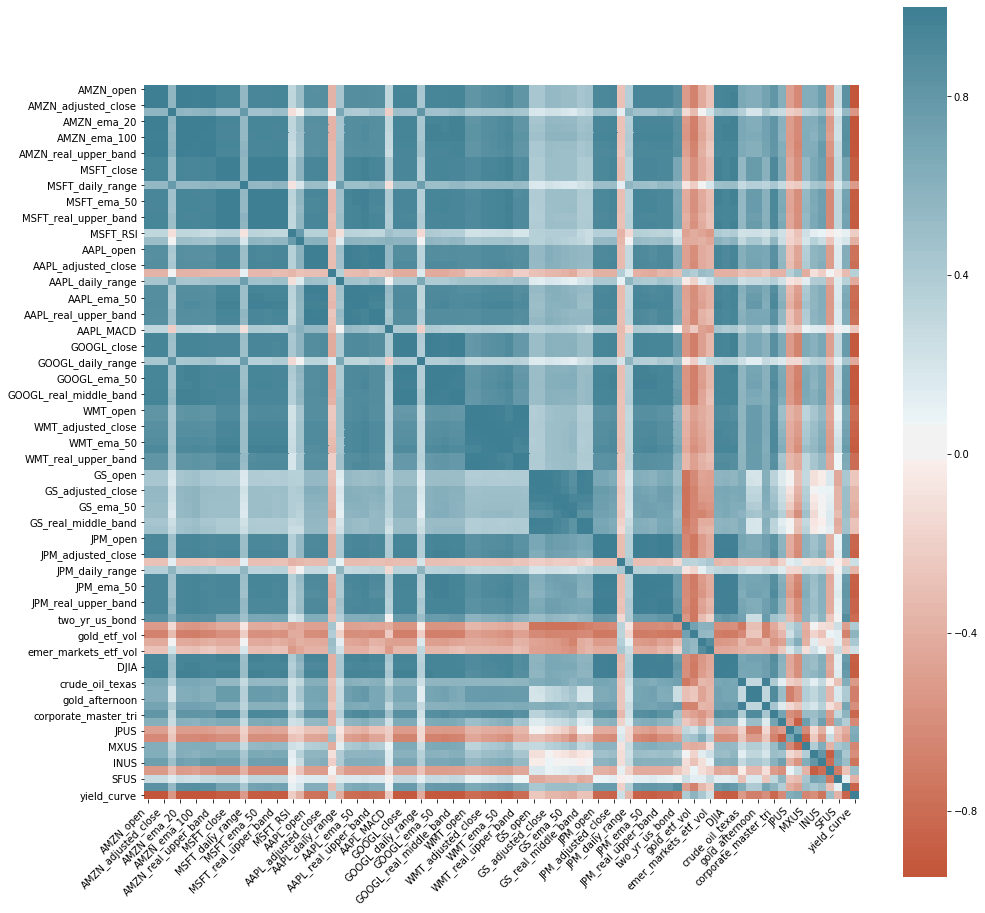

In [5]:
###########################
##### PLOT THE CORRELATIONS
###########################

plt.figure(figsize=(16, 16))

ax = sns.heatmap(
    corr, 
#     vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.show()

In [6]:
#####################
##### FILTER FEATURES
#####################

if len([x for x in low_corr_feats if x in data.columns]) != 0:
    
    print('Removing', len(low_corr_feats), 'low correlation ( rho <', rho, ') features')
    
    data.drop(labels=low_corr_feats, axis=1, inplace=True)
    
print('Dataset dimensions:', data.shape)

corr_feats = list(data.columns)

Removing 57 low correlation ( rho < 0.3 ) features
Dataset dimensions: (1241, 91)


In [7]:
###################
##### SAVE THE DATA
###################

# Save the data

data.to_csv('data/filt_data.csv', sep=',', header=True, index=True)